In [1]:
import utils.unet_utils as ut
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from utils.unet_utils import train
from DataSet import ImSegDataSet
import time
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [2]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.xavier_normal_(m.weight.data)
  elif isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_normal_(m.weight.data)

In [3]:
#Use the cross entropy loss, since we have more than two classes per pixel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def CriterionCombo(input,target):

    #Get One Hot encoding of the true labels
    y_true = torch.nn.functional.one_hot(target,24).permute(0,3,1,2).float()

    assert y_true.shape == input.shape
    
    BCELoss = smp.losses.SoftBCEWithLogitsLoss()
    TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)

    L1 = BCELoss(y_pred = input,y_true = y_true)
    L2 = TverskyLoss(y_pred = input,y_true = y_true)

    loss = 0.5 * L1 + 0.5 * L2

    return loss

crit = CriterionCombo

model = ut.UNet(3, 24, [64, 128, 256, 512]).to(device)
model.apply(initialize_weights)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#Data set and data loader for the training set
DS_training = ImSegDataSet(PathToDataSet="./data/train_set/",mode = "train")
DL_training = DataLoader(dataset=DS_training,batch_size=1,shuffle=True)

#Data set and data loader for the validation set
print("\n")
DS_validation = ImSegDataSet(PathToDataSet="./data/validation_set/",mode = "validation")
DL_validation = DataLoader(dataset=DS_validation,batch_size=5)

'''
result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 5, 
    buffer_update_freq = 5,
    buffer_pick_size = 3,
    n_epochs = 5,
    patch_size = 32,
    tag = "test_run_1_2023-03-20"
    )
'''

result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 1, 
    buffer_update_freq = 1,
    buffer_pick_size = 1,
    n_epochs = 5,
    patch_size = 128,
    tag = "test{}".format(time.strftime("%d-%H%M%S", time.gmtime(time.time()))),
    rotation = False,
    mirroring = False,
    scaling_factor = 30
    )

#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	train
	Number of instances:	300
	Image: (C,H,W):		(3,4000,6000)
#########################################################################################


#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	validation
	Number of instances:	50
	Image: (C,H,W):		(3,4000,6000)
#########################################################################################
Epoch: 1 



  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([1, 1, 128, 128])


  0%|          | 0/300 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 128, 128] to have 3 channels, but got 1 channels instead

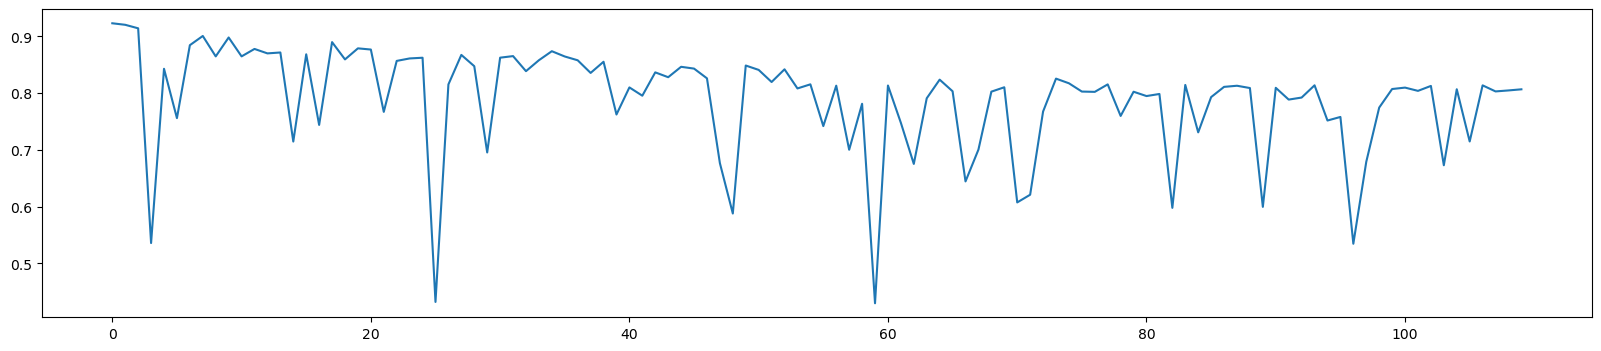

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test26-221120/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)